In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from itertools import chain

In [2]:
# Set random seed for numpy
np.random.seed(11)
# Set random seed for pytorch
torch.manual_seed(11)
# Set random seed for pytorch running in GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(11)

In [3]:
UCI_train_features = np.load("uci/UCI_train_features_32.npy")
UCI_test_features = np.load("uci/UCI_test_features_32.npy")
UCI_train_labels = np.load("uci/UCI_train_labels_32.npy",allow_pickle=True)
UCI_test_labels = np.load("uci/UCI_test_labels_32.npy",allow_pickle=True)

In [4]:
UCI_train_labels = list(chain.from_iterable(UCI_train_labels))
UCI_test_labels = list(chain.from_iterable(UCI_test_labels))

In [5]:
UCI_train_labels = np.asarray(list(chain.from_iterable(zip(UCI_train_labels,UCI_train_labels))))
UCI_test_labels = np.asarray(list(chain.from_iterable(zip(UCI_test_labels,UCI_test_labels))))

In [6]:
# Hyperparameters
num_epochs = 15
batch_size = 10
learning_rate = 0.0001

In [7]:
UCI_train_labels = UCI_train_labels.astype(int) - 1
UCI_test_labels = UCI_test_labels.astype(int) - 1

In [8]:
# Transform to torch tensor
tensor_UCI_train_features = torch.Tensor(UCI_train_features) 
tensor_UCI_train_labels = torch.Tensor(UCI_train_labels)
tensor_UCI_test_features = torch.Tensor(UCI_test_features) 
tensor_UCI_test_labels = torch.Tensor(UCI_test_labels)
# Add one dimension of channel
tensor_UCI_train_features = torch.unsqueeze(tensor_UCI_train_features, 1)
tensor_UCI_test_features = torch.unsqueeze(tensor_UCI_test_features, 1)
# Create datset
train_dataset_UCI = TensorDataset(tensor_UCI_train_features,tensor_UCI_train_labels)
test_dataset_UCI = TensorDataset(tensor_UCI_test_features,tensor_UCI_test_labels)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_UCI, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_UCI, batch_size=batch_size, shuffle=False)

In [10]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

29408
11788


In [11]:
for images,labels in train_loader:
    print(images.size())
    break

torch.Size([10, 1, 36, 32])


### Construct LSTM

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=5, stride=1, padding=2)  ### 10,32,18,384
        self.pool = nn.MaxPool2d(2, 2) ### 10,32,9,192 2nd layer
        self.conv2 = nn.Conv2d(32,64, kernel_size=5, stride=1, padding=2) ###10,64,9,192 3rd layer
    
    def forward(self, x):
        batch,c,h,w = x.size()
        x = self.pool(F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x))) ### 10,64,9,192/ 5,64,9,192
        x = x.view(batch,-1) ### 10,110592 
        return x

In [14]:

class CNN_LSTM(nn.Module): 
    def __init__(self):
        super(CNN_LSTM, self).__init__() ###(num_samples,timesteps,input_dim). 
        self.cnn = Cnn()
        self.rnn = nn.LSTM(
            input_size=144, ### [32 <- 216] / [64<-432]/ [128<-864] or single [32 <- 72] / [64<-144]/ [128<-288]
            hidden_size=36, 
            num_layers=5, ### change [1,3,5]
            batch_first=True)
        self.linear = nn.Linear(36,6)

    def forward(self, x):
        batch,c,h,w = x.size()
        c_out = self.cnn(x) ### 10,110592
        r_in = c_out.view(batch,128,-1) ### 10,1,8192
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        return F.log_softmax(r_out2, dim=1)


In [15]:
# Choose CPU or GPU
# model = ConvNet() #CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Combine

In [16]:
%%time
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.to(device).long())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/15], Step [100/2941], Loss: 1.7765, Accuracy: 20.00%
Epoch [1/15], Step [200/2941], Loss: 1.5987, Accuracy: 20.00%
Epoch [1/15], Step [300/2941], Loss: 1.3368, Accuracy: 40.00%
Epoch [1/15], Step [400/2941], Loss: 1.2361, Accuracy: 40.00%
Epoch [1/15], Step [500/2941], Loss: 1.5166, Accuracy: 10.00%
Epoch [1/15], Step [600/2941], Loss: 1.2123, Accuracy: 30.00%
Epoch [1/15], Step [700/2941], Loss: 1.3902, Accuracy: 20.00%
Epoch [1/15], Step [800/2941], Loss: 1.2109, Accuracy: 20.00%
Epoch [1/15], Step [900/2941], Loss: 1.2399, Accuracy: 40.00%
Epoch [1/15], Step [1000/2941], Loss: 1.1205, Accuracy: 50.00%
Epoch [1/15], Step [1100/2941], Loss: 1.1685, Accuracy: 20.00%
Epoch [1/15], Step [1200/2941], Loss: 1.1452, Accuracy: 40.00%
Epoch [1/15], Step [1300/2941], Loss: 1.1406, Accuracy: 30.00%
Epoch [1/15], Step [1400/2941], Loss: 1.1627, Accuracy: 30.00%
Epoch [1/15], Step [1500/2941], Loss: 1.1263, Accuracy: 30.00%
Epoch [1/15], Step [1600/2941], Loss: 1.1918, Accuracy: 10.00%
E

Epoch [5/15], Step [1600/2941], Loss: 0.6063, Accuracy: 80.00%
Epoch [5/15], Step [1700/2941], Loss: 0.4510, Accuracy: 100.00%
Epoch [5/15], Step [1800/2941], Loss: 0.4495, Accuracy: 90.00%
Epoch [5/15], Step [1900/2941], Loss: 0.8916, Accuracy: 50.00%
Epoch [5/15], Step [2000/2941], Loss: 0.8299, Accuracy: 60.00%
Epoch [5/15], Step [2100/2941], Loss: 0.5445, Accuracy: 80.00%
Epoch [5/15], Step [2200/2941], Loss: 0.9170, Accuracy: 40.00%
Epoch [5/15], Step [2300/2941], Loss: 0.8977, Accuracy: 60.00%
Epoch [5/15], Step [2400/2941], Loss: 0.7297, Accuracy: 60.00%
Epoch [5/15], Step [2500/2941], Loss: 0.5395, Accuracy: 80.00%
Epoch [5/15], Step [2600/2941], Loss: 0.8938, Accuracy: 40.00%
Epoch [5/15], Step [2700/2941], Loss: 0.4419, Accuracy: 100.00%
Epoch [5/15], Step [2800/2941], Loss: 0.5928, Accuracy: 60.00%
Epoch [5/15], Step [2900/2941], Loss: 1.0383, Accuracy: 50.00%
Epoch [6/15], Step [100/2941], Loss: 0.5774, Accuracy: 90.00%
Epoch [6/15], Step [200/2941], Loss: 0.3897, Accuracy:

Epoch [10/15], Step [200/2941], Loss: 0.3111, Accuracy: 90.00%
Epoch [10/15], Step [300/2941], Loss: 0.3739, Accuracy: 80.00%
Epoch [10/15], Step [400/2941], Loss: 0.7031, Accuracy: 60.00%
Epoch [10/15], Step [500/2941], Loss: 0.8464, Accuracy: 60.00%
Epoch [10/15], Step [600/2941], Loss: 0.7399, Accuracy: 80.00%
Epoch [10/15], Step [700/2941], Loss: 0.5258, Accuracy: 70.00%
Epoch [10/15], Step [800/2941], Loss: 0.5393, Accuracy: 70.00%
Epoch [10/15], Step [900/2941], Loss: 0.5367, Accuracy: 70.00%
Epoch [10/15], Step [1000/2941], Loss: 0.7241, Accuracy: 60.00%
Epoch [10/15], Step [1100/2941], Loss: 0.4791, Accuracy: 70.00%
Epoch [10/15], Step [1200/2941], Loss: 0.5215, Accuracy: 80.00%
Epoch [10/15], Step [1300/2941], Loss: 0.5054, Accuracy: 90.00%
Epoch [10/15], Step [1400/2941], Loss: 0.4002, Accuracy: 80.00%
Epoch [10/15], Step [1500/2941], Loss: 0.9249, Accuracy: 40.00%
Epoch [10/15], Step [1600/2941], Loss: 0.7492, Accuracy: 70.00%
Epoch [10/15], Step [1700/2941], Loss: 0.4189, A

Epoch [14/15], Step [1500/2941], Loss: 0.7148, Accuracy: 70.00%
Epoch [14/15], Step [1600/2941], Loss: 0.5125, Accuracy: 80.00%
Epoch [14/15], Step [1700/2941], Loss: 0.4920, Accuracy: 70.00%
Epoch [14/15], Step [1800/2941], Loss: 0.6623, Accuracy: 60.00%
Epoch [14/15], Step [1900/2941], Loss: 0.6057, Accuracy: 70.00%
Epoch [14/15], Step [2000/2941], Loss: 0.6472, Accuracy: 60.00%
Epoch [14/15], Step [2100/2941], Loss: 0.7560, Accuracy: 80.00%
Epoch [14/15], Step [2200/2941], Loss: 0.4986, Accuracy: 80.00%
Epoch [14/15], Step [2300/2941], Loss: 0.9577, Accuracy: 70.00%
Epoch [14/15], Step [2400/2941], Loss: 0.4461, Accuracy: 80.00%
Epoch [14/15], Step [2500/2941], Loss: 0.7069, Accuracy: 70.00%
Epoch [14/15], Step [2600/2941], Loss: 0.8437, Accuracy: 40.00%
Epoch [14/15], Step [2700/2941], Loss: 0.4500, Accuracy: 70.00%
Epoch [14/15], Step [2800/2941], Loss: 0.2170, Accuracy: 90.00%
Epoch [14/15], Step [2900/2941], Loss: 0.2977, Accuracy: 90.00%
Epoch [15/15], Step [100/2941], Loss: 0.

In [17]:
classes = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

Test Accuracy of the model on the UCIHAR test images: 70.25788937902952 %


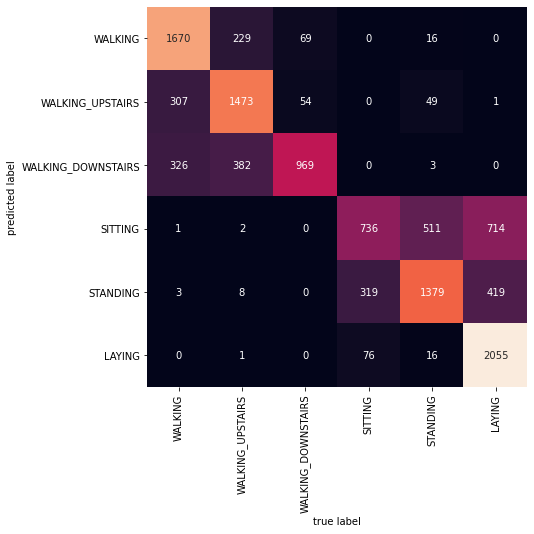

In [18]:

from sklearn import metrics
import seaborn as sns
# Test the model on GPU
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the UCIHAR test images: {} %'.format((correct / total) * 100))

mat = metrics.confusion_matrix(torch.cat(all_predictions).cpu(), torch.cat(all_labels).cpu())
plt.figure(figsize=(7,7))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');